In [ ]:
!nvidia-smi

Mon May 15 02:39:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.2 MB/s eta 0:00:00


In [ ]:
%%capture
!pip install transformers==4.19.2
# !pip install git+https://github.com/huggingface/transformers
!pip install rouge_score

In [ ]:
from datasets import load_metric

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/HeadingsForParagraphs/wikiHow.csv")

In [ ]:
df.head()

,title,heading,paragraph
0,How to Change Doctors: 10 Steps (with Pictures...,Know when to switch.,Changing doctors is a serious decision. Someti...
1,How to Change Doctors: 10 Steps (with Pictures...,"Decide what to tell your former doctor, if any...","When switching doctors, you need to decide whe..."
2,How to Change Doctors: 10 Steps (with Pictures...,Ask your former doctor for a referral.,"Sometimes, switching doctors is not a result o..."
3,How to Change Doctors: 10 Steps (with Pictures...,Ask around.,"Seek out the advice of people you trust, like ..."
4,How to Change Doctors: 10 Steps (with Pictures...,Search online.,There are a variety of ways to find a doctor t...


In [ ]:
print(df.shape)
df = df.dropna()
print(df.shape)

(94161, 3)
(92658, 3)


In [ ]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(92658, 3)
(71861, 3)


In [ ]:
df['length'] = df.paragraph.map(lambda x: len(x.split(" ")))

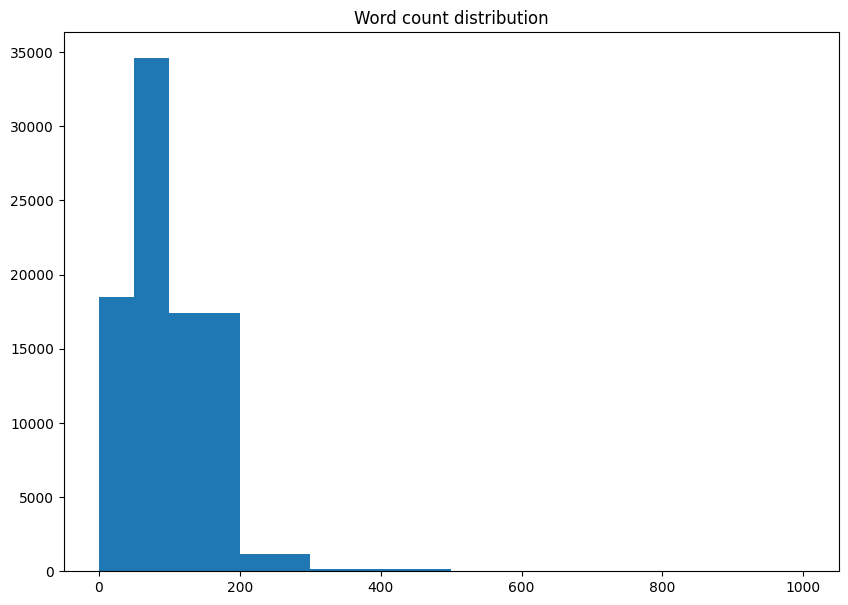

In [ ]:
numOfWords = df.length
from matplotlib import pyplot as plt
 
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.hist(numOfWords.to_numpy(), bins = [0, 50, 100, 200, 300, 500, 1000])
 
plt.title("Word count distribution")
 
# show plot
plt.show()

In [ ]:
tempDf = df[df.length <= 300]

In [ ]:
tempDf.shape

(71696, 4)

In [ ]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=4):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
max_input_length = 1024
max_output_length = 64
batch_size = 16

In [ ]:
def process_data_to_model_inputs(batch):
    # tokenize the inputs and labels
    inputs = tokenizer(
        batch["paragraph"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
    )
    outputs = tokenizer(
        batch["heading"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length,
    )

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    # create 0 global_attention_mask lists
    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [0 for _ in range(len(batch["input_ids"][0]))]
    ]

    # since above lists are references, the following line changes the 0 index for all samples
    batch["global_attention_mask"][0][0] = 1
    batch["labels"] = outputs.input_ids

    # We have to make sure that the PAD token is ignored
    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]

    return batch

In [ ]:
import numpy as np
train, validate, test = np.split(tempDf.sample(frac=1, random_state=42), [int(.6*len(df)), int(.7*len(df))])

In [ ]:
train.shape

(43116, 4)

In [ ]:
validate.shape

(20, 4)

In [ ]:
validate = validate[:20]

In [ ]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(validate)

In [ ]:
train_dataset = train_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["title", "heading", "paragraph", "length", "__index_level_0__"],
)

Map:   0%|          | 0/43116 [00:00<?, ? examples/s]

In [ ]:
val_dataset = val_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["title", "heading", "paragraph", "length", "__index_level_0__"],
)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [ ]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)
val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)

In [ ]:
len(train_dataset['global_attention_mask'][0])

1024

In [ ]:
len(val_dataset['labels'][0])

64

In [ ]:
from transformers import AutoModelForSeq2SeqLM
led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)

Downloading:   0%|          | 0.00/618M [00:00<?, ?B/s]

In [ ]:
led.config.num_beams = 2
led.config.max_length = 64
led.config.min_length = 2
led.config.length_penalty = 2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3

In [ ]:
rouge = load_metric("rouge")

<ipython-input-30-6f1857dc142f>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")


In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(
        predictions=pred_str, references=label_str, rouge_types=["rouge2"]
    )["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import transformers
transformers.logging.set_verbosity_info()

In [ ]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    output_dir="./",
    logging_steps=5,
    eval_steps=10,
    save_steps=10,
    save_total_limit=2,
    gradient_accumulation_steps=4,
    num_train_epochs=10
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Seq2SeqTrainer(
    model=led,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [ ]:
trainer.train(resume_from_checkpoint=True)

Loading model from ./checkpoint-490).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 43116
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 6730
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 490
  Will skip the first 0 epochs then the first 1960 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/1960 [00:00<?, ?it/s]

Step,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
500,1.866000,1.930385,0.115000,0.087000,0.096800
510,1.935700,1.885883,0.143600,0.121400,0.126300
520,1.850400,1.886283,0.121900,0.102600,0.107900
530,1.868500,1.876038,0.120600,0.099900,0.106300
540,1.922200,1.900846,0.075000,0.077500,0.076900
550,1.930700,1.889064,0.092600,0.093800,0.091700
560,1.915200,1.922863,0.139300,0.115100,0.122500
570,1.874300,1.899491,0.148900,0.106800,0.121900
580,1.869400,1.898124,0.131500,0.099800,0.109600
590,1.886600,1.916279,0.136800,0.112200,0.117300


***** Running Evaluation *****
  Num examples = 20
  Batch size = 16
Saving model checkpoint to ./checkpoint-500
Configuration saved in ./checkpoint-500/config.json
Model weights saved in ./checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./checkpoint-500/tokenizer_config.json
Special tokens file saved in ./checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 20
  Batch size = 16
Saving model checkpoint to ./checkpoint-510
Configuration saved in ./checkpoint-510/config.json
Model weights saved in ./checkpoint-510/pytorch_model.bin
tokenizer config file saved in ./checkpoint-510/tokenizer_config.json
Special tokens file saved in ./checkpoint-510/special_tokens_map.json
Deleting older checkpoint [checkpoint-490] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 20
  Batch size = 16
Saving model checkpoint to ./checkpoint-520
Configuration saved in ./checkpoint-520/config.json
Model weights saved in ./checkpoint-5

## Testing

In [ ]:
import pandas as pd
sample_paragraph = "The reason why I loved the top-down culture at Apple is that important decisions are taken faster. Having an expert giving you green light or not keeps the momentum. How many times in a bottom-up culture, do we spend weeks and weeks, sometimes even months, trying to get alignment with +10 people, because every single person needs to agree with the point of view? It is exhausting. So again, my experience is that having that one leader to look up to to help guide decisions is time-saving, it helps us focus on the design craft, instead of project managing"
data = [sample_paragraph]
df = pd.DataFrame(data, columns=['paragraph'])
df['paragraph'][0]
from datasets import Dataset
df_test = Dataset.from_pandas(df)
df_test

Dataset({
    features: ['paragraph'],
    num_rows: 1
})

In [ ]:
from datasets import load_metric
import torch

from datasets import load_dataset, load_metric
from transformers import LEDTokenizer, LEDForConditionalGeneration

# load tokenizer
tokenizer = LEDTokenizer.from_pretrained("/content/checkpoint-10")
model = LEDForConditionalGeneration.from_pretrained("/content/checkpoint-10").to("cuda").half()


def generate_answer(batch):
  inputs_dict = tokenizer(batch["paragraph"], padding="max_length", max_length=512, return_tensors="pt", truncation=True)
  input_ids = inputs_dict.input_ids.to("cuda")
  attention_mask = inputs_dict.attention_mask.to("cuda")
  global_attention_mask = torch.zeros_like(attention_mask)
#   # put global attention on <s> token
#   global_attention_mask[:, 0] = 1

  predicted_abstract_ids = model.generate(input_ids, attention_mask=attention_mask, global_attention_mask=global_attention_mask)
  batch["generated_heading"] = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
  return batch


result = df_test.map(generate_answer, batched=True, batch_size=2)

# load rouge
# rouge = load_metric("rouge")

# print("Result:", rouge.compute(predictions=result["predicted_content"], references=result["content"], rouge_types=["rouge2"])["rouge2"].mid)

Didn't find file /content/checkpoint-10/added_tokens.json. We won't load it.
loading file /content/checkpoint-10/vocab.json
loading file /content/checkpoint-10/merges.txt
loading file None
loading file /content/checkpoint-10/special_tokens_map.json
loading file /content/checkpoint-10/tokenizer_config.json
loading configuration file /content/checkpoint-10/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Input ids are automatically padded from 512 to 1024 to be a multiple of `config.attention_window`: 1024


In [ ]:
result["generated_heading"]

['Have an expert to guide you.']